In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import Preprocess
import tensorflow as tf
import rrn

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load Data and user/item vectors

In [2]:
df = pd.read_csv('../data/class/rating_data.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5

user_vectors = np.load('../data/class/user_vectors.npy')
item_vectors = np.load('../data/class/item_vectors.npy')

user_time_interval = 3 * 30
item_time_interval = 3 * 30

# Top List preprocess

In [3]:
df_item = pd.DataFrame(df['iid'])
df_item.column = ['iid']
df_item['freq'] = df_item.groupby('iid')['iid'].transform('count')
df_item = df_item.drop_duplicates()
df_item = df_item.sort_values(by=['freq'], ascending=False)
top_list = df_item['iid'].as_matrix()

top_ranks = []
for i in range(1, 10):
    top_ranks.append(top_list[:i*10])

# Data preprocessing

In [4]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def train_test_split(df, time_interval, split_rate= 0.125):
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    df_train = df[df['timestamp'] < split_time]
    df_test = df[df['timestamp'] >= split_time]
    
    return df_train, df_test

In [5]:
userList = np.unique(df['uid'])
itemList = np.unique(df['iid'])
user_map = get_map(userList)
item_map = get_map(itemList)
initial_time = min(df['timestamp'])

df_train, df_test = train_test_split(df, user_time_interval * 24 * 3600)

## Set Hyperparameter

In [6]:
def get_hparas(batch_size, vector_length, time_interval, name):
    hparas={
        'NAME': name,
        'EMBED_UNITS': 40,
        'BATCH_SIZE': batch_size,
        'LSTM_UNITS': 40,
        'LATENT_UNITS': 20,
        'VECTOR_LENGTH': vector_length+3,
        'TRAIN_TIME_ELAPSE': 21,
        'TEST_TIME_ELAPSE': 3,
        'STATIONARY_LENGTH': 20,
        'TIME_INTERVAL': time_interval,
    }
    
    return hparas

item_train_list = np.unique(df_train['iid'])
item_test_list = np.unique(df_test['iid'])

user_train_hparas = get_hparas(64, len(itemList), user_time_interval, 'USER')
item_train_hparas = get_hparas(len(item_train_list), len(userList), item_time_interval, 'ITEM')
user_test_hparas = get_hparas(64, len(itemList), user_time_interval, 'USER')
item_test_hparas = get_hparas(len(item_test_list), len(userList), item_time_interval, 'ITEM')

# Train

100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


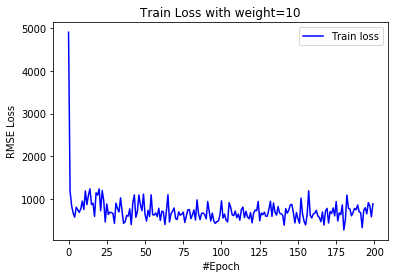

In [11]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='rmse', weighted=10)

model.train(df_train, user_map, item_map, initial_time, top_rank=top_ranks[0])
model.model_save('class_rmse_weighted')

train_loss = model.log['train_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.title("Train Loss with weight=10")
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('RMSE Loss')
plt.savefig("Train_Loss_with_weight_10.jpg")
plt.show()

100%|██████████| 200/200 [00:47<00:00,  4.25it/s]


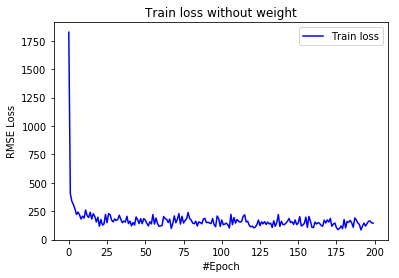

In [12]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='rmse', weighted=None)

model.train(df_train, user_map, item_map, initial_time, top_rank=None)
model.model_save('class_rmse')

train_loss = model.log['train_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.title("Train loss without weight")
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('RMSE Loss')
plt.savefig("Train_Loss_without_weight.jpg")
plt.show()

# Test

## Class dataset
**RMSE** (no weighted)

In [7]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='rmse')

model.model_load('class_rmse')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt
top10 rmse loss: 0.052712
top20 rmse loss: 0.067790
top30 rmse loss: 0.074238
top40 rmse loss: 0.083599
top50 rmse loss: 0.087414
top60 rmse loss: 0.089672
top70 rmse loss: 0.091890
top80 rmse loss: 0.092935
top90 rmse loss: 0.095332

All items rmse loss: 0.095698


In [15]:
print (len(np.unique(df_test['iid'])))

98


## Class dataset
**RMSE** (with weighted)

In [8]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='rmse')

model.model_load('class_rmse_weighted')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_weighted.ckpt
top10 rmse loss: 0.049237
top20 rmse loss: 0.063854
top30 rmse loss: 0.069879
top40 rmse loss: 0.079201
top50 rmse loss: 0.083094
top60 rmse loss: 0.085345
top70 rmse loss: 0.087551
top80 rmse loss: 0.088551
top90 rmse loss: 0.090995

All items rmse loss: 0.091320


## Itri dataset 
**RMSE** (no weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='rmse')

model.model_load('itri_rmse')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

## Itri dataset 
**RMSE** (with weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='rmse')

model.model_load('itri_rmse_weighted')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

## Itri dataset 
**LOG_LOSS** (without weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

## Itri dataset 
**LOG_LOSS** (with weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss_weighted')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

# Debug Section

In [9]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, lr=0.01, epochs=200, loss_function='rmse')

In [10]:
prep = Preprocess(
    df_test, user_map, item_map, initial_time, 'rating', 
    user_time_interval=model.user_hparas['TIME_INTERVAL'], 
    item_time_interval=model.item_hparas['TIME_INTERVAL'])

user_input, item_input, ground_truth, batch_user, batch_item = prep.gen_batch(0)
u_static_vector = prep.get_latent_vector(batch_user, user_vectors, 'user')
i_static_vector = prep.get_latent_vector(batch_item, item_vectors, 'item')
weight_list = prep.get_list_weight(top_ranks[2], model.weighted)

In [12]:
output = model.sess.run(
    model.logits,
    feed_dict={
        model.user_input: user_input,
        model.item_input: item_input,
        model.ground_truth: ground_truth,
        model.user_stationary_factor: u_static_vector,
        model.item_stationary_factor: i_static_vector,
    })

In [13]:
print (output[0][1])

[ 5.81169128  4.52204275  4.99284697  4.33437443  2.87153411  4.41719961
  5.11110163  3.8524456   5.12133312  3.47401977  4.73781967  5.58775377
  5.38044691  4.51378775  4.8392911   5.02687311  5.25166225  4.83331108
  3.79914141  4.57301521  4.86301661  3.9047823   4.35889626  4.39681053
  5.84805632  4.35857296  5.06222534  4.83609009  5.34923601  5.81556129
  4.57040977  5.44479847  3.79669833  4.31056404  6.18707085  4.92283201
  4.87507582  5.10336065  4.93733215  4.18735218  4.51359081  4.88879919
  4.72976255  6.79192543  5.00381994  4.99619627  4.9037075   4.88151073
  4.74242163  4.58906984  4.25060606  4.74207973  4.40714836  4.99892473
  5.31768703  4.46811581  4.83798456  5.13660288  4.17998695  5.1624074
  4.8057065   5.01132298  4.23186779  5.04250097  4.16088009  3.4084959
  5.34545898  4.27645206  4.70597649  4.46476793  3.76662111  5.79070234
  4.52456379  4.483922    5.67783737  4.80467415  5.33378077  5.03865623
  4.24382067  4.85177517  4.29969931  5.41783094  3.9

In [ ]:
filter_ = tf.nn.relu(tf.sign(model.ground_truth))

filtered = model.sess.run(filter_, feed_dict={model.ground_truth: ground_truth})

In [ ]:
filtered[0]